# Credit Card Fraud Detection
### Recognize fraudulent credit card transactions
### 5.2 Unsupervised learning (AE)
             KwangMyung Yu, Senior Researcher, Korea Electric Power Corporation

참고자료 : https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30 #중요

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import recall_score,precision_score, accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

In [3]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [4]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", 
                 fontsize = 18)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
data = pd.concat([X_train, y_train], axis = 1  )
X_train_normal = X_train.iloc[y_train[y_train['Class']==0].index.tolist(), :]
X_train_fraud = X_train.iloc[y_train[y_train['Class']==1].index.tolist(), :]

In [6]:
X_train_normal.shape

(199020, 29)

In [7]:
X_train_fraud.shape

(344, 29)

### Autoencoder

In [8]:
X_train_normal.shape

(199020, 29)

모델 만들기

In [9]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

In [10]:
input_dim = X_train_normal.shape[1]
encoding_dim = 20

In [11]:
input_layer = Input(shape=(input_dim,))

encoder = Dense(encoding_dim, activation='tanh',
               activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim/2), activation='relu')(encoder)

decoder = Dense(int(encoding_dim/2), activation='tanh')(encoder)
decoder = Dense(encoding_dim, activation='tanh')(decoder)

output = Dense(units = X_train_normal.shape[1], activation='relu')(decoder)
autoencoder = Model(inputs = input_layer, outputs = output)

In [12]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                609       
Total params: 1,749
Trainable params: 1,749
Non-trainable params: 0
___________________________________________________________

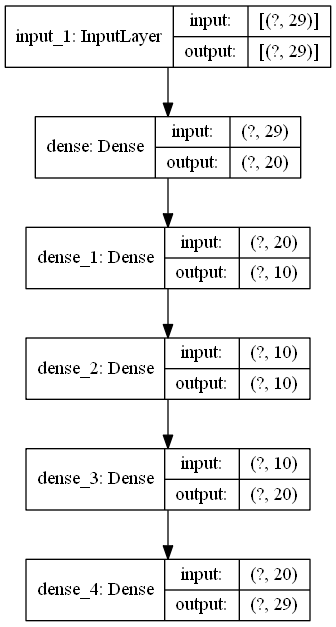

In [16]:
plot_model(autoencoder, show_shapes=True)

In [17]:
history = autoencoder.fit(X_train_normal, X_train_normal,
                    epochs=50, batch_size=32, shuffle=True)

Train on 199020 samples
Epoch 1/50
199020/199020 [==============================] - 13s 65us/sample - loss: 0.0533 - accuracy: 0.9815
Epoch 2/50
199020/199020 [==============================] - 13s 63us/sample - loss: 0.0481 - accuracy: 0.9921
Epoch 3/50
199020/199020 [==============================] - 13s 64us/sample - loss: 0.0480 - accuracy: 0.9921
Epoch 4/50
199020/199020 [==============================] - 13s 64us/sample - loss: 0.0361 - accuracy: 0.9914
Epoch 5/50
199020/199020 [==============================] - 13s 63us/sample - loss: 0.0281 - accuracy: 0.9922
Epoch 6/50
199020/199020 [==============================] - 13s 63us/sample - loss: 0.0238 - accuracy: 0.9921
Epoch 7/50
199020/199020 [==============================] - 13s 65us/sample - loss: 0.0238 - accuracy: 0.9922
Epoch 8/50
199020/199020 [==============================] - 13s 63us/sample - loss: 0.0238 - accuracy: 0.9922
Epoch 9/50
199020/199020 [==============================] - 13s 65us/sample - loss: 0.0238 - acc

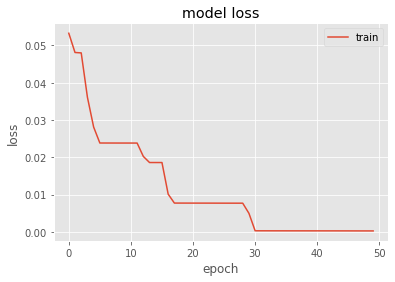

In [23]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

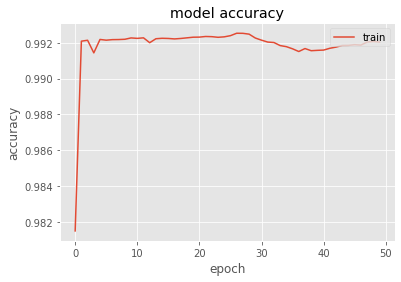

In [24]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

In [25]:
X_recon = autoencoder.predict(X_test)

In [27]:
X_recon.shape

(85443, 29)

In [28]:
y_test.shape

(85443, 1)

In [30]:
mse = np.mean(np.power(X_test - X_recon, 2), axis=1)

In [31]:
error_df = pd.DataFrame()
error_df['reconstruction_error'] = mse
error_df['y_test'] = y_test

In [33]:
error_df[error_df['y_test']==1]

,reconstruction_error,y_test
293,0.002290,1
694,0.033399,1
922,0.004682,1
3347,0.021086,1
3538,0.003369,1
...,...,...
83329,0.036571,1
84008,0.000235,1
84055,0.008012,1
84231,0.009642,1


In [34]:
error_df

,reconstruction_error,y_test
0,0.000060,0
1,0.000173,0
2,0.000108,0
3,0.000025,0
4,0.000230,0
...,...,...
85438,0.000068,0
85439,0.000154,0
85440,0.000533,0
85441,0.000183,0


(0, 0.04)

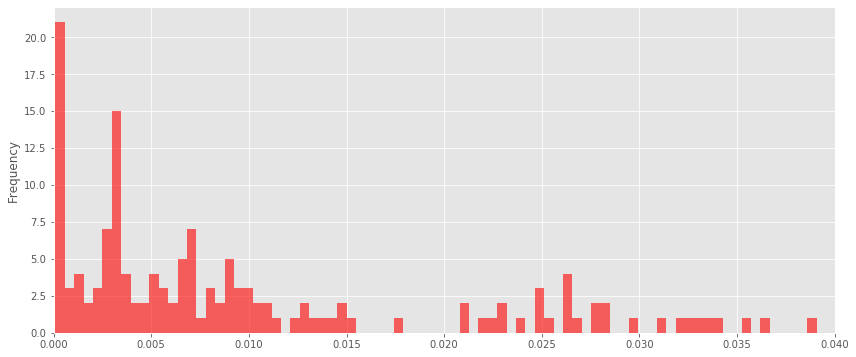

In [44]:
fig, ax = plt.subplots(figsize = (14, 6))
error_df[error_df['y_test']==1]['reconstruction_error'].plot(kind = 'hist',
                                bins = 100, alpha = 0.6, label = 'Fraud',
                                ax = ax, color ='r')
#error_df[error_df['y_test']==0]['reconstruction_error'].plot(kind = 'hist',
#                                bins = 100, alpha = 0.6, label = 'Normal',
#                                ax = ax, color ='b')
ax.set_xlim([0, 0.04])

In [61]:
threshold = 0.0035

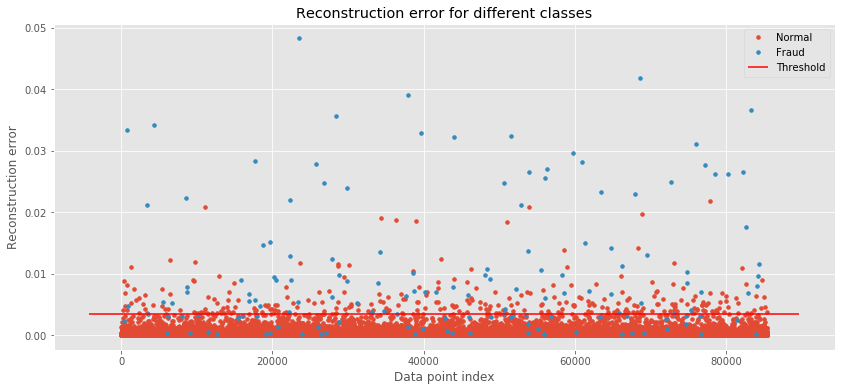

In [62]:
groups = error_df.groupby('y_test')
fig, ax = plt.subplots(figsize = (14, 6))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [63]:
y_pred = [1 if e > threshold else 0 for e \
          in error_df['reconstruction_error'].values]

Test Result(Base_AE)
accuracy :  0.9960675538078017
precsion : 0.24866310160427807
recall :  0.6283783783783784


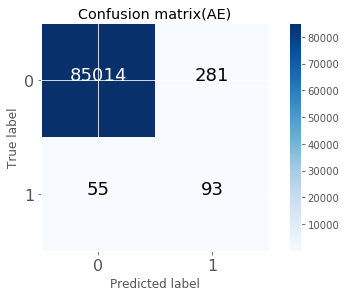

In [64]:
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Test Result(Base_AE)')
print('accuracy : ', acc)
print('precsion :', precision)
print('recall : ', recall)

class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix(AE)')
plt.show()